In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_QUANT_INT8_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

print(MODEL_TF)
print(MODEL_NO_QUANT_TFLITE)
print(MODEL_QUANT_INT8_TFLITE)
print(MODEL_TFLITE_MICRO)

models/model
models/model_no_quant.tflite
models/model.tflite
models/model.cc


In [ ]:
!unzip -qn "/content/drive/MyDrive/dataset.zip" -d /content/ > /dev/null

In [ ]:
TRAIN_PATH = "/content/dataset/"

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                validation_split=0.2)

# Tamaño del lote (imágenes a procesar por el modelo al mismo tiempo)
BATCH_SIZE = 32

# Importar datos desde los directorios y convertirlos en lotes de tensores
train_data = train_datagen.flow_from_directory(TRAIN_PATH,
                                               batch_size=BATCH_SIZE, # tamaño del lote
                                               target_size=(224, 224), # convertir todas las imágenes a 224 x 224
                                              #  color_mode="grayscale",
                                               class_mode="binary", # tipo de problema, usar 'binary' si tuviesemos dos clases
                                               seed=42, # semilla para generar las mismas selecciones durante los experimentos
                                               shuffle=True,
                                               subset="training")

valid_data = train_datagen.flow_from_directory(TRAIN_PATH,
                                               batch_size=32,
                                               target_size=(224, 224),
                                              #  color_mode="grayscale",
                                               class_mode="binary",
                                               seed=42,
                                               shuffle=True,
                                               subset="validation")

Found 1334 images belonging to 2 classes.
Found 333 images belonging to 2 classes.


In [ ]:
!unzip -qn "/content/drive/MyDrive/test.zip" -d /content/ > /dev/null

In [ ]:
TEST_PATH = "/content/test/"

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Tamaño del lote (imágenes a procesar por el modelo al mismo tiempo)
BATCH_SIZE = 32

# Importar datos desde los directorios y convertirlos en lotes de tensores
test_data = test_datagen.flow_from_directory(TEST_PATH,
                                               batch_size=BATCH_SIZE, # tamaño del lote
                                               target_size=(224, 224), # convertir todas las imágenes a 224 x 224
                                              #  color_mode="grayscale",
                                              class_mode="binary", # tipo de problema, usar 'binary' si tuviesemos dos clases
                                               seed=42, # semilla para generar las mismas selecciones durante los experimentos
                                               shuffle=True)

Found 236 images belonging to 2 classes.


In [ ]:
# Crear datos sintéticos
train_datagen_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # Nota: esta y las siguientes 4 líneas definen como se crearan nuevas instancias
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(TRAIN_PATH,
                                            batch_size=32,
                                            target_size=(224, 224),
                                            #  color_mode="grayscale",
                                            class_mode="binary",
                                            seed=42,
                                            shuffle=True)

Found 1667 images belonging to 2 classes.


(32, 224, 224, 3)


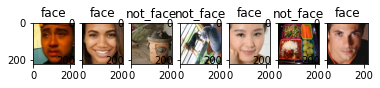

In [ ]:
categories = ["face", "not_face"]
img, label = valid_data.next()
print(img.shape)   #  (1,256,256,3)
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7)
ax1.imshow(img[0], cmap="gray")
ax1.set_title(categories[int(label[0])])
ax2.imshow(np.squeeze(img[1]), cmap="gray")
ax2.set_title(categories[int(label[1])])
ax3.imshow(np.squeeze(img[2]), cmap="gray")
ax3.set_title(categories[int(label[2])])
ax4.imshow(np.squeeze(img[3]), cmap="gray")
ax4.set_title(categories[int(label[3])])
ax5.imshow(np.squeeze(img[4]), cmap="gray")
ax5.set_title(categories[int(label[4])])
ax6.imshow(np.squeeze(img[5]), cmap="gray")
ax6.set_title(categories[int(label[5])])
ax7.imshow(np.squeeze(img[6]), cmap="gray")
ax7.set_title(categories[int(label[6])])
plt.show()

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 1,025
Non-trainable

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 1,025
Non-trainable

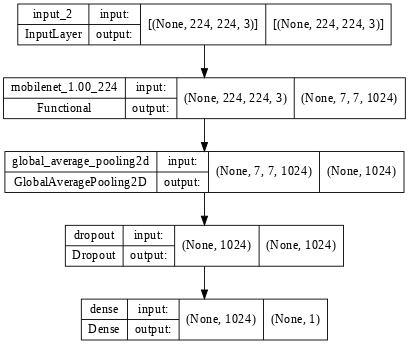

In [ ]:
base_learning_rate = 0.0001
epochs = 5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
loss0, accuracy0 = model.evaluate(valid_data)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 3s 111ms/step - loss: 0.8401 - accuracy: 0.3934
initial loss: 0.84
initial accuracy: 0.39


In [ ]:
history = model.fit(train_data_augmented,
                    epochs=epochs,
                    validation_data=valid_data)

Epoch 1/5
53/53 [==============================] - 26s 463ms/step - loss: 0.6299 - accuracy: 0.6605 - val_loss: 0.4591 - val_accuracy: 0.8348
Epoch 2/5
53/53 [==============================] - 22s 424ms/step - loss: 0.3870 - accuracy: 0.8284 - val_loss: 0.2743 - val_accuracy: 0.9369
Epoch 3/5
53/53 [==============================] - 23s 426ms/step - loss: 0.2613 - accuracy: 0.9154 - val_loss: 0.1799 - val_accuracy: 0.9790
Epoch 4/5
53/53 [==============================] - 22s 422ms/step - loss: 0.1756 - accuracy: 0.9604 - val_loss: 0.1298 - val_accuracy: 0.9880
Epoch 5/5
53/53 [==============================] - 22s 425ms/step - loss: 0.1428 - accuracy: 0.9706 - val_loss: 0.0962 - val_accuracy: 0.9910


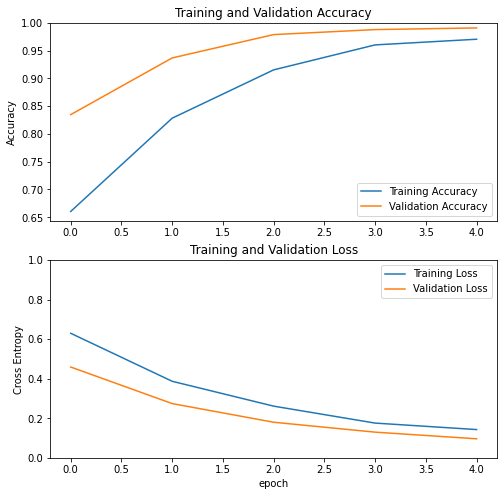

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_data)
print("final loss: {:.2f}".format(loss))
print("final accuracy: {:.2f}".format(accuracy))

8/8 [==============================] - 1s 87ms/step - loss: 0.0574 - accuracy: 1.0000
final loss: 0.06
final accuracy: 1.00


(32,)


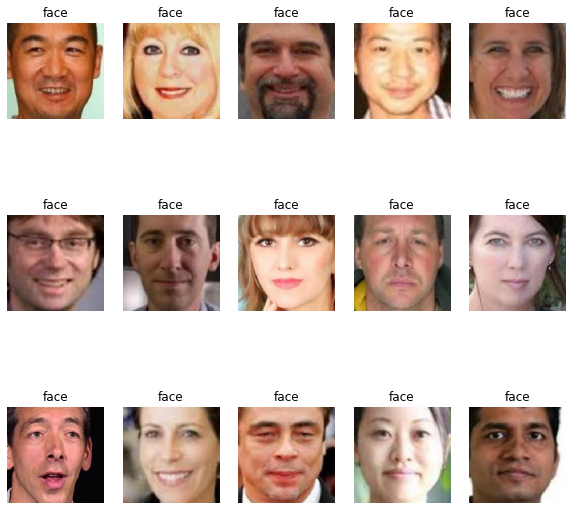

In [ ]:
categories = ["face", "not_face"]

image_batch, label = test_data.next()

pred = model.predict(image_batch).flatten()
print(pred.shape)
# pred = tf.nn.sigmoid(pred)
pred = tf.where(pred < 0.5, 0, 1)


plt.figure(figsize=(10, 10))
for i in range(15):
  ax = plt.subplot(3, 5, i + 1)
  ax.imshow(image_batch[i], cmap="gray")
  plt.title(categories[pred[i]])
  plt.axis("off")

In [ ]:
# Save the model to disk
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models/model/assets


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

12807828

In [ ]:
import cv2

def preprocess_image(image, data_type, output_shape):
  image_resized = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_resized = cv2.resize(image_resized, output_shape)

  if(data_type == np.int8):
    image_resized = (image_resized * 255) - 128
    image_resized = np.int8(np.expand_dims(image_resized, axis=0))
  elif(data_type == np.float32):
    image_resized = np.float32(np.expand_dims(image_resized, axis=0))
  else:
    print("Data type not valid")

  return image_resized

def representative_dataset():
  train_image_batch, train_label_batch = next(iter(train_data))
  for image in train_image_batch:
    yield [preprocess_image(image, np.float32, (224,224))]

In [ ]:
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

In [ ]:
open(MODEL_QUANT_INT8_TFLITE, "wb").write(model_tflite)

3514720

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=MODEL_QUANT_INT8_TFLITE)
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Datos de entrada ==")
print("Nombre:", input_details[0]['name'])
print("Tamaño:", input_details[0]['shape'])
print("Tipo de datos:", input_details[0]['dtype'])

print("\n== Datos de salida ==")
print("Nombre:", output_details[0]['name'])
print("Tamaño:", output_details[0]['shape'])
print("Tipo de datos:", output_details[0]['dtype'])

== Datos de entrada ==
Nombre: serving_default_input_2:0
Tamaño: [  1 224 224   3]
Tipo de datos: <class 'numpy.int8'>

== Datos de salida ==
Nombre: StatefulPartitionedCall:0
Tamaño: [1 1]
Tipo de datos: <class 'numpy.int8'>


In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Datos de entrada ==")
print("Nombre:", input_details[0]['name'])
print("Tamaño:", input_details[0]['shape'])
print("Tipo de datos:", input_details[0]['dtype'])

print("\n== Datos de salida ==")
print("Nombre:", output_details[0]['name'])
print("Tamaño:", output_details[0]['shape'])
print("Tipo de datos:", output_details[0]['dtype'])

== Datos de entrada ==
Nombre: serving_default_input_2:0
Tamaño: [ 32 224 224   3]
Tipo de datos: <class 'numpy.int8'>

== Datos de salida ==
Nombre: StatefulPartitionedCall:0
Tamaño: [32  5]
Tipo de datos: <class 'numpy.int8'>


In [ ]:
image_batch, label_batch = next(iter(valid_data))

for i, image in enumerate(image_batch):
  image_batch[i] = np.expand_dims(preprocess_image(image, np.int8, (224,224)), axis=0)

image_batch = image_batch.astype('int8')

In [ ]:
import time

tflite_interpreter.allocate_tensors()
tflite_interpreter.set_tensor(input_details[0]['index'], image_batch)

tflite_interpreter.invoke()

start_time = time.time()
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index']).flatten()
end_time = time.time()

print("Tamaño de los resultados de la predicción:", tflite_model_predictions.shape)
print(tflite_model_predictions)

Tamaño de los resultados de la predicción: (32,)
[-121 -116 -117 -121  123  102  -86  118 -121   99 -109   41   36 -103
   63 -112 -119 -121   75 -119 -118  107 -108 -116 -117  -65 -111  -51
 -117 -111 -124  123]


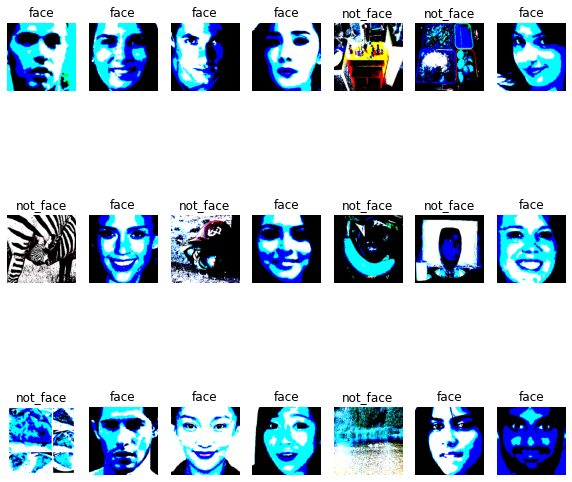

In [ ]:
# tflite_model_predictions = tf.where(tflite_model_predictions < 0.5, 0, 1)
new_pred = []
for i, pred in enumerate(tflite_model_predictions):
  if pred < 0:
    tflite_model_predictions[i] = 0
  else:
    tflite_model_predictions[i] = 1

plt.figure(figsize=(10, 10))
for i in range(21):
  ax = plt.subplot(3, 7, i + 1)
  ax.imshow(np.float32(image_batch[i]), cmap="gray")
  plt.title(categories[tflite_model_predictions[i]])
  plt.axis("off")

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_QUANT_INT8_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_QUANT_INT8_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [816 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea